In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

## Video segmentation and tracking with SAM 3

This notebook demonstrates how to use SAM 3 for interactive video segmentation and dense tracking. It covers the following capabilities:

- **Text prompts**: Using natural language descriptions to segment objects (e.g., "person", "shoe")
- **Point prompts**: Adding positive/negative clicks to segment and refine objects

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

# <a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam3/blob/main/notebooks/sam3_video_predictor_example.ipynb">
#   <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
# </a>

In [ ]:
using_colab = False

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib scikit-learn
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam3.git'

In [ ]:
!nvidia-smi

## Set-up

In this example, we allow running inference either on a single GPU or multiple GPUs.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6"
import sam3
import torch

sam3_root = os.path.join(os.path.dirname(sam3.__file__), "..")


# use all available GPUs on the machine
gpus_to_use = range(torch.cuda.device_count())
# # use only a single GPU
# torch.cuda.set_device(4)
# gpus_to_use = [torch.cuda.current_device()]

/home/haoxiang/sam3/sam3/model_builder.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
from sam3.model_builder import build_sam3_video_predictor

predictor = build_sam3_video_predictor(checkpoint_path="/data/haoxiang/sam3/models/facebook/sam3/sam3.pt",gpus_to_use=gpus_to_use)


INFO 2026-01-31 07:06:20,804 2626100 sam3_video_predictor.py: 300: using the following GPU IDs: [0, 1, 2]
INFO 2026-01-31 07:06:20,938 2626100 sam3_video_predictor.py: 316: 


	*** START loading model on all ranks ***


INFO 2026-01-31 07:06:20,942 2626100 sam3_video_predictor.py: 318: loading model on rank=0 with world_size=3 -- this could take a while ...
INFO 2026-01-31 07:06:50,726 2626100 sam3_video_base.py: 125: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2026-01-31 07:07:10,839 2626100 sam3_video_predictor.py: 320: loading model on rank=0 with world_size=3 -- DONE locally
INFO 2026-01-31 07:07:10,845 2626100 sam3_video_predictor.py: 377: spawning 2 worker processes
/home/haoxiang/sam3/sam3/model_builder.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_r

#### Inference and visualization utils

In [3]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sam3.visualization_utils import (
    load_frame,
    prepare_masks_for_visualization,
    visualize_formatted_frame_output,
)

# font size for axes titles
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["figure.titlesize"] = 12


def propagate_in_video(predictor, session_id):
    # we will just propagate from frame 0 to the end of the video
    outputs_per_frame = {}
    for response in predictor.handle_stream_request(
        request=dict(
            type="propagate_in_video",
            session_id=session_id,
        )
    ):
        outputs_per_frame[response["frame_index"]] = response["outputs"]

    return outputs_per_frame


def abs_to_rel_coords(coords, IMG_WIDTH, IMG_HEIGHT, coord_type="point"):
    """Convert absolute coordinates to relative coordinates (0-1 range)

    Args:
        coords: List of coordinates
        coord_type: 'point' for [x, y] or 'box' for [x, y, w, h]
    """
    if coord_type == "point":
        return [[x / IMG_WIDTH, y / IMG_HEIGHT] for x, y in coords]
    elif coord_type == "box":
        return [
            [x / IMG_WIDTH, y / IMG_HEIGHT, w / IMG_WIDTH, h / IMG_HEIGHT]
            for x, y, w, h in coords
        ]
    else:
        raise ValueError(f"Unknown coord_type: {coord_type}")

### Loading an example video

We assume that the video is stored as either **a list of JPEG frames with filenames like `<frame_index>.jpg`** or **an MP4 video**.

Note that you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

In [4]:
# "video_path" needs to be either a JPEG folder or a MP4 video file
# video_path = f"{sam3_root}/assets/videos/0001"
video_path = f"{sam3_root}/assets/videos/camera0_rgb.mp4"

In [5]:
# load "video_frames_for_vis" for visualization purposes (they are not used by the model)
if isinstance(video_path, str) and video_path.endswith(".mp4"):
    cap = cv2.VideoCapture(video_path)
    video_frames_for_vis = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        video_frames_for_vis.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
else:
    video_frames_for_vis = glob.glob(os.path.join(video_path, "*.jpg"))
    try:
        # integer sort instead of string sort (so that e.g. "2.jpg" is before "11.jpg")
        video_frames_for_vis.sort(
            key=lambda p: int(os.path.splitext(os.path.basename(p))[0])
        )
    except ValueError:
        # fallback to lexicographic sort if the format is not "<frame_index>.jpg"
        print(
            f'frame names are not in "<frame_index>.jpg" format: {video_frames_for_vis[:5]=}, '
            f"falling back to lexicographic sort."
        )
        video_frames_for_vis.sort()

### Opening an inference session on this video

SAM 3 requires stateful inference for interactive video segmentation, so we need to initialize an **inference session** on this video.

During initialization, it loads all the video frames and stores their pixels in the session state.

In [6]:
response = predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=video_path,
    )
)
session_id = response["session_id"]

frame loading (OpenCV) [rank=0]:   2%|▏         | 5/201 [00:00<00:04, 46.09it/s]

frame loading (OpenCV) [rank=2]: 100%|██████████| 201/201 [00:02<00:00, 69.29it/s]


### Video promptable concept segmentation with text

Using SAM 3 you can describe objects using natural language, and the model will automatically detect and track all instances of that object throughout the video.

In the example below, we add a text prompt on frame 0 and propagation throughout the video. Here we use the text prompt "person" to detect all people in the video. SAM 3 will automatically identify multiple person instances and assign each a unique object ID.

Note that the first call might be slower due to setting up buffers. **You can rerun all the cells below when measuring speed.**

In [7]:
# note: in case you already ran one text prompt and now want to switch to another text prompt
# it's required to reset the session first (otherwise the results would be wrong)
_ = predictor.handle_request(
    request=dict(
        type="reset_session",
        session_id=session_id,
    )
)

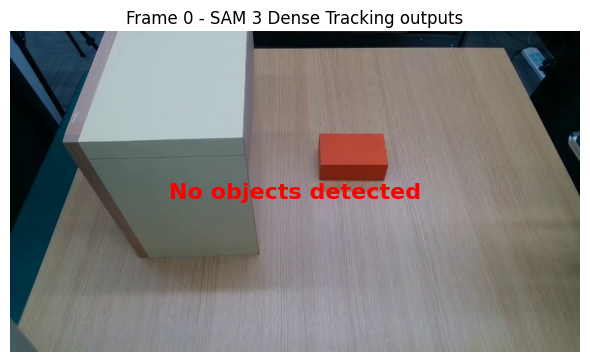

In [20]:
prompt_text_str = "robot arm"
# prompt_text_str = "black end-effector"
frame_idx = 0  # add a text prompt on frame 0
response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        text=prompt_text_str,
    )
)
out = response["outputs"]

plt.close("all")
visualize_formatted_frame_output(
    frame_idx,
    video_frames_for_vis,
    outputs_list=[prepare_masks_for_visualization({frame_idx: out})],
    titles=["SAM 3 Dense Tracking outputs"],
    figsize=(6, 4),
)

propagate_in_video:   0%|          | 0/201 [00:00<?, ?it/s]

propagate_in_video: 0it [00:00, ?it/s]

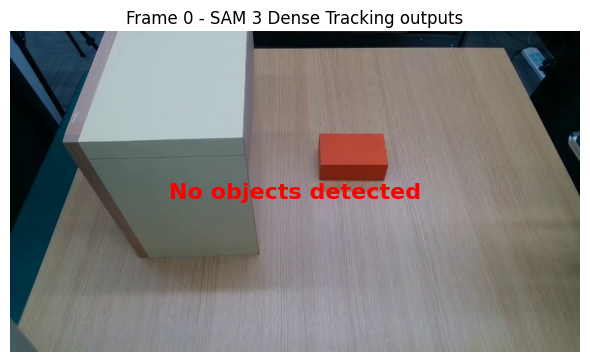

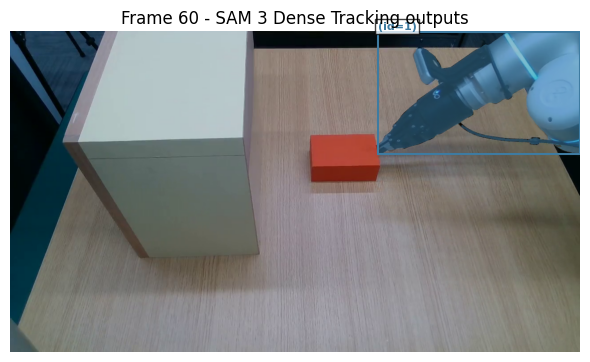

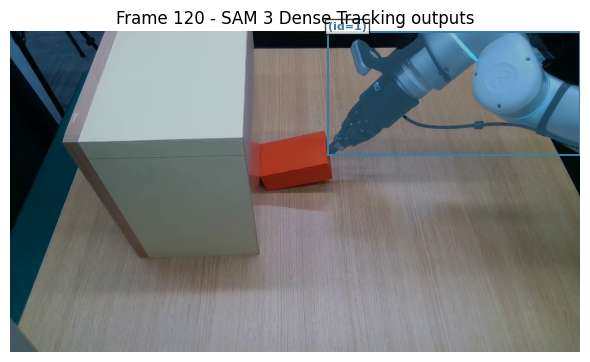

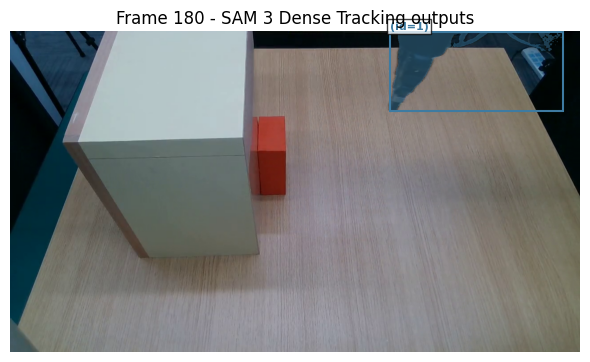

In [21]:
# now we propagate the outputs from frame 0 to the end of the video and collect all outputs
outputs_per_frame = propagate_in_video(predictor, session_id)

# finally, we reformat the outputs for visualization and plot the outputs every 60 frames
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)

vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    visualize_formatted_frame_output(
        frame_idx,
        video_frames_for_vis,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

###  Removing objects

We can remove individual objects using their id.

As an example, let's remove object 2 (which is the dancer in the front).

In [13]:
# we pick id 2, which is the dancer in the front
obj_id = 2
response = predictor.handle_request(
    request=dict(
        type="remove_object",
        session_id=session_id,
        obj_id=obj_id,
    )
)

100%|██████████| 270/270 [00:00<00:00, 51277.43it/s]
0it [00:00, ?it/s]
100%|██████████| 270/270 [00:00<00:00, 20173.90it/s]
0it [00:00, ?it/s]


  0%|          | 0/270 [00:00<?, ?it/s]

0it [00:00, ?it/s]

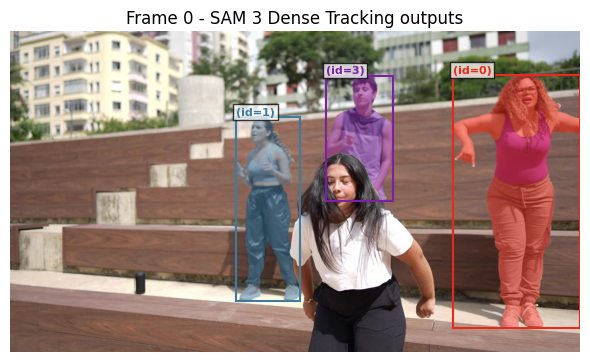

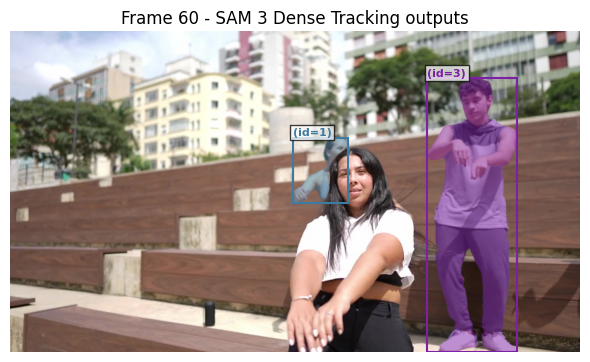

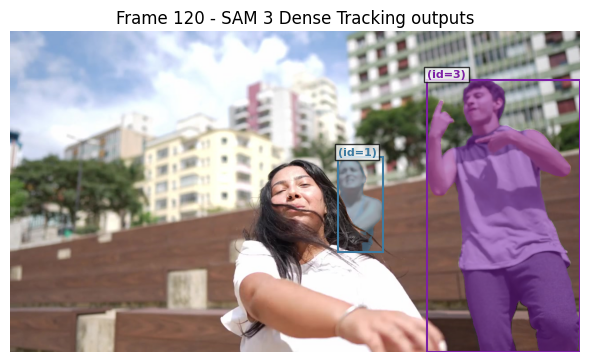

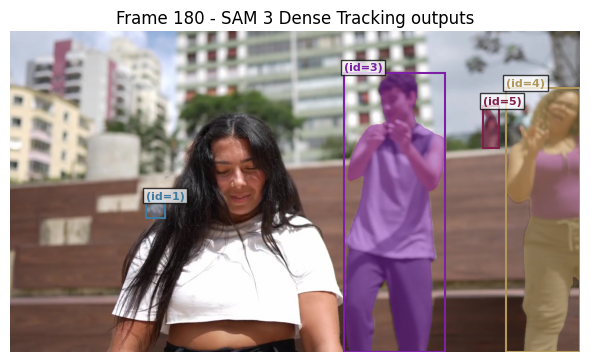

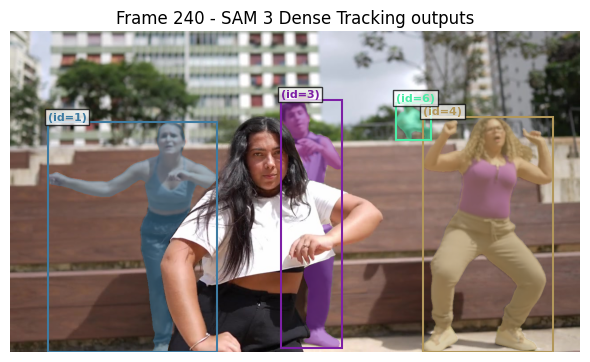

In [14]:
# now we propagate the outputs from frame 0 to the end of the video and collect all outputs
outputs_per_frame = propagate_in_video(predictor, session_id)

# finally, we reformat the outputs for visualization and plot the outputs every 60 frames
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)

vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    visualize_formatted_frame_output(
        frame_idx,
        video_frames_for_vis,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

### Adding new objects with point prompts

We can add new objects through point prompts.

Assuming that we've changed our mind, and now that we want to add back the dancer in the front (whom we just removed in the step above). We can use interactive clicks to add her back.

In [22]:
sample_img = Image.fromarray(load_frame(video_frames_for_vis[0]))

IMG_WIDTH, IMG_HEIGHT = sample_img.size
print(sample_img.size)

(1280, 720)


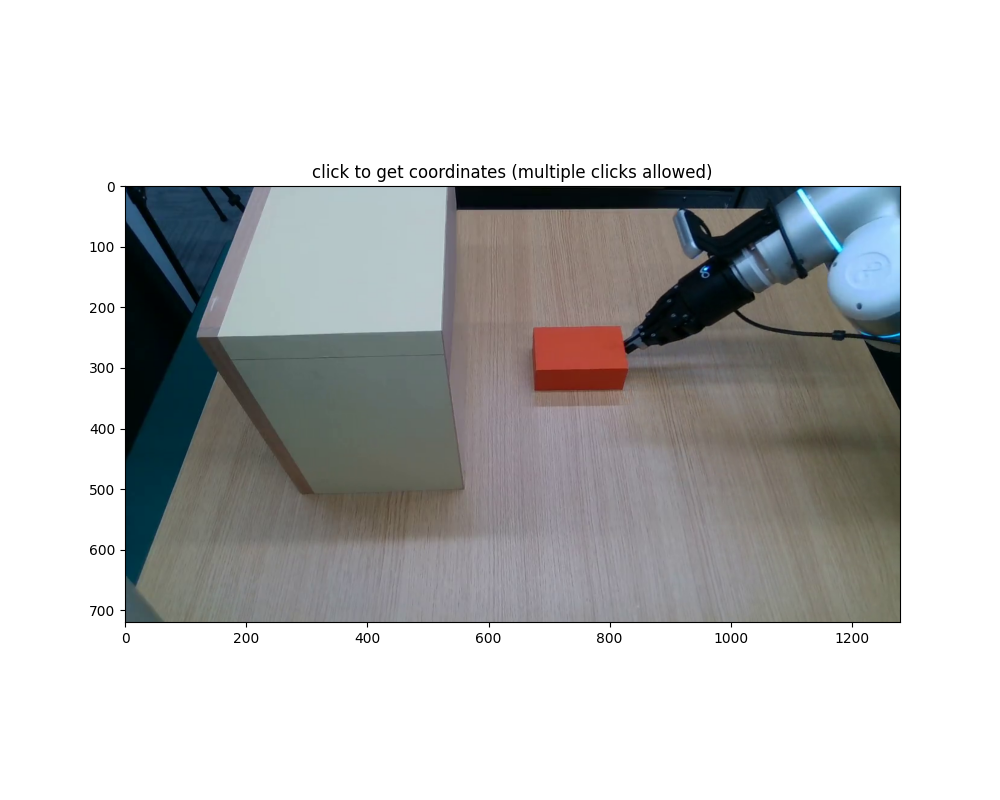

In [28]:
# 第二步：启用 widget 后端
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np

# 加载图像
sample_img = Image.fromarray(load_frame(video_frames_for_vis[60]))

# 创建交互式图
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(sample_img)
ax.set_title("click to get coordinates (multiple clicks allowed)")
coords = []

def onclick(event):
    if event.inaxes:
        x, y = int(event.xdata), int(event.ydata)
        coords.append([x, y])
        ax.plot(x, y, 'r*', markersize=15)
        ax.text(x+10, y, f'({x},{y})', color='yellow', fontsize=12, 
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        fig.canvas.draw()
        print(f"coords: np.array([[{x}, {y}]])")

fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [15]:
# let's add back the dancer via point prompts.
# we will use a single positive click to add the dancer back.

frame_idx = 0
obj_id = 2
points_abs = np.array(
    [
        [760, 550],  # positive click
    ]
)
# positive clicks have label 1, while negative clicks have label 0
labels = np.array([1])

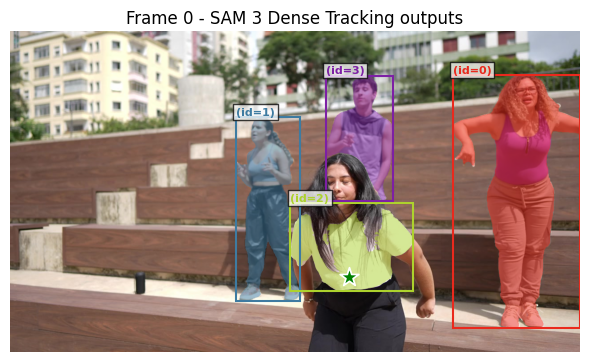

In [19]:
# convert points and labels to tensors; also convert to relative coordinates
points_tensor = torch.tensor(
    abs_to_rel_coords(points_abs, IMG_WIDTH, IMG_HEIGHT, coord_type="point"),
    dtype=torch.float32,
)
points_labels_tensor = torch.tensor(labels, dtype=torch.int32)

response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        points=points_tensor,
        point_labels=points_labels_tensor,
        obj_id=obj_id,
    )
)
out = response["outputs"]

plt.close("all")
visualize_formatted_frame_output(
    frame_idx,
    video_frames_for_vis,
    outputs_list=[prepare_masks_for_visualization({frame_idx: out})],
    titles=["SAM 3 Dense Tracking outputs"],
    figsize=(6, 4),
    points_list=[points_abs],
    points_labels_list=[labels],
)

  0%|          | 0/270 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

100%|██████████| 270/270 [00:36<00:00,  7.31it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]

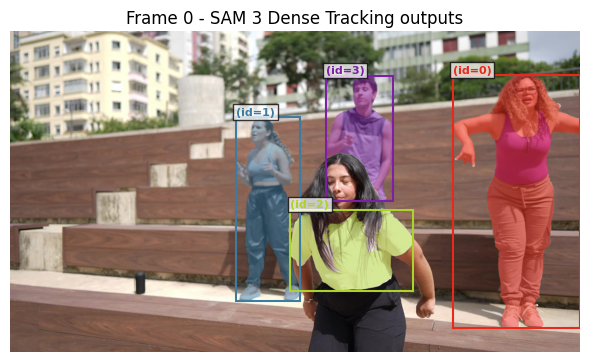

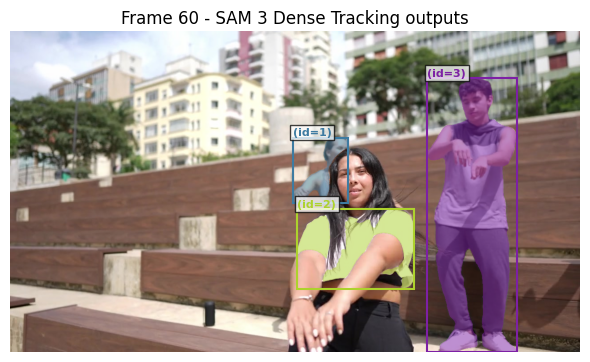

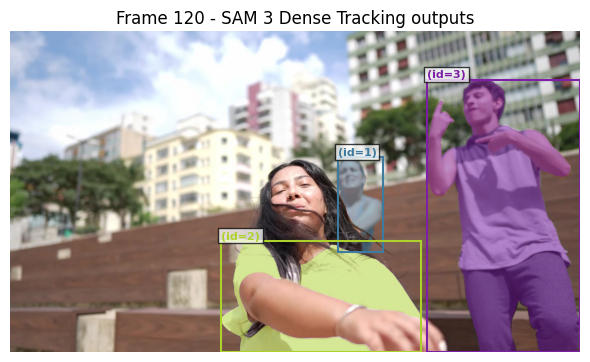

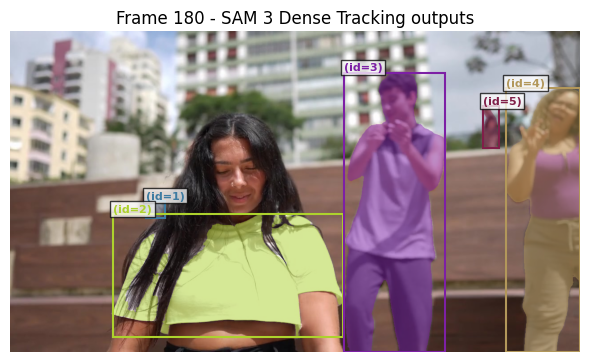

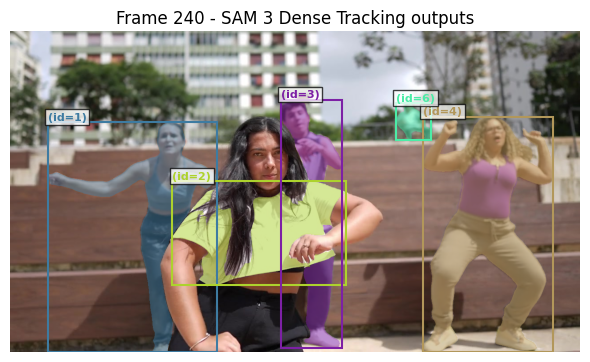

In [20]:
# now we propagate the outputs from frame 0 to the end of the video and collect all outputs
outputs_per_frame = propagate_in_video(predictor, session_id)

# finally, we reformat the outputs for visualization and plot the outputs every 60 frames
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)

vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    visualize_formatted_frame_output(
        frame_idx,
        video_frames_for_vis,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

### Refining an existing object with point prompts

We can also refine the segmentation mask of an existing object through point prompts.

Assuming that we've changed our mind (again) -- for Object ID 2 (the dancer in the front whom we just added back in the step above), now we only want to segment her T-shirt instead of her whole body. We can adjust the segmentation mask with a few more positive and negative clicks.

In [53]:
# For the dancer in the front, suppose now we only want to segment her T-shirt instead of her whole body
# we will use 2 positive clicks and 2 negative clicks to select her shirt.

frame_idx = 60
obj_id = 2
points_abs = np.array(
    [
        # [740, 450],  # positive click
        # [760, 630],  # negative click
        # [840, 640],  # negative click
        # [760, 550],  # positive click
        # negative
        [897,174],
        [909,219],
        [861,222],
        [861,247],
        [840,252],
        # positive
        [926,65],
        [922,88],
        # [954,141]
        # [982,187]
        # [1084,91]
        # [1215,158],
        # [1190,35],
        [1134,238]
    ]
)
# positive clicks have label 1, while negative clicks have label 0
# labels = np.array([1, 0, 0, 1])
labels = np.array([0,0,0,0,0,1,1,1])

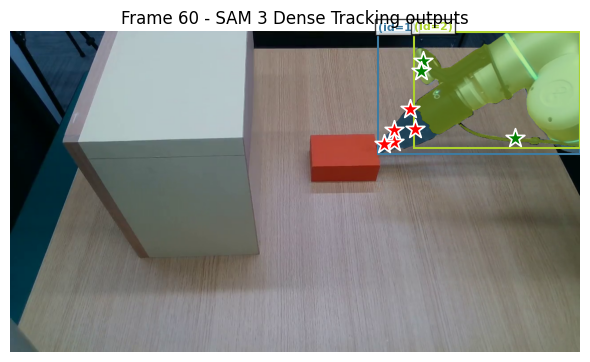

In [54]:
# convert points and labels to tensors; also convert to relative coordinates
points_tensor = torch.tensor(
    abs_to_rel_coords(points_abs, IMG_WIDTH, IMG_HEIGHT, coord_type="point"),
    dtype=torch.float32,
)
points_labels_tensor = torch.tensor(labels, dtype=torch.int32)

response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        points=points_tensor,
        point_labels=points_labels_tensor,
        obj_id=obj_id,
    )
)
out = response["outputs"]

plt.close("all")
visualize_formatted_frame_output(
    frame_idx,
    video_frames_for_vis,
    outputs_list=[prepare_masks_for_visualization({frame_idx: out})],
    titles=["SAM 3 Dense Tracking outputs"],
    figsize=(6, 4),
    points_list=[points_abs],
    points_labels_list=[labels],
)

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

100%|██████████| 201/201 [00:22<00:00,  8.99it/s]
0it [00:00, ?it/s]
100%|██████████| 201/201 [00:22<00:00,  8.99it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]

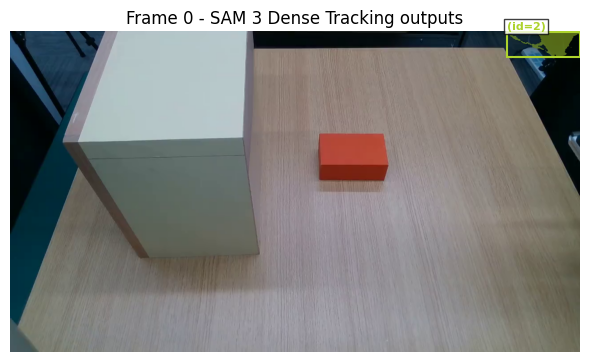

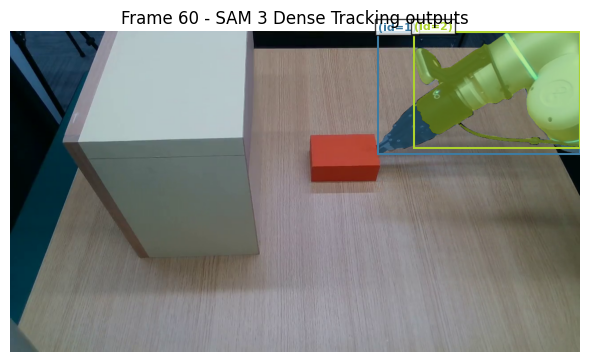

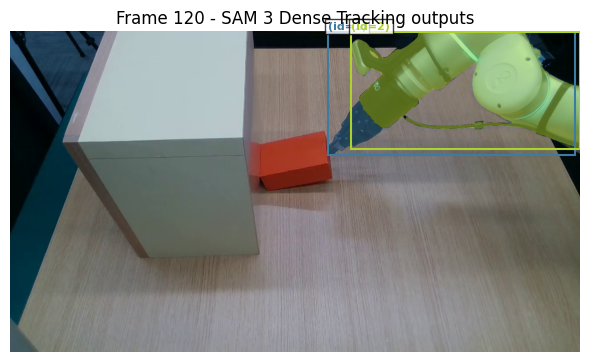

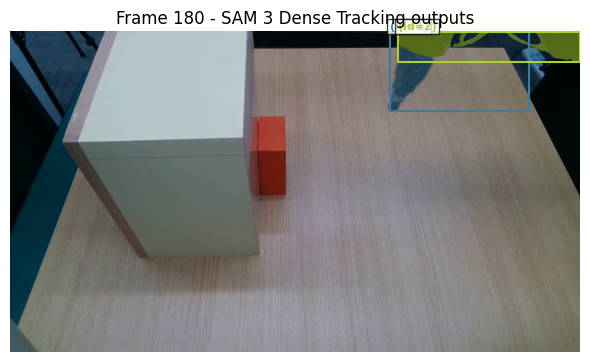

In [55]:
# now we propagate the outputs from frame 0 to the end of the video and collect all outputs
outputs_per_frame = propagate_in_video(predictor, session_id)

# finally, we reformat the outputs for visualization and plot the outputs every 60 frames
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)

vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    visualize_formatted_frame_output(
        frame_idx,
        video_frames_for_vis,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

### Close session

Each session is tied to a single video. We can close the session after inference to free up its resources.

(Then, you may start a new session on another video.)

In [56]:
# finally, close the inference session to free its GPU resources
# (you may start a new session on another video)
_ = predictor.handle_request(
    request=dict(
        type="close_session",
        session_id=session_id,
    )
)

INFO 2026-01-31 08:33:12,384 2626285 sam3_video_predictor.py: 251: removed session 501be0fd-b2d5-482d-926e-cffc52b51ddc; live sessions: [], GPU memory: 5117 MiB used and 11190 MiB reserved (max over time: 10724 MiB used and 11190 MiB reserved)
INFO 2026-01-31 08:33:12,431 2626286 sam3_video_predictor.py: 251: removed session 501be0fd-b2d5-482d-926e-cffc52b51ddc; live sessions: [], GPU memory: 5093 MiB used and 10912 MiB reserved (max over time: 10425 MiB used and 10912 MiB reserved)
INFO 2026-01-31 08:33:13,071 2626100 sam3_video_predictor.py: 251: removed session 501be0fd-b2d5-482d-926e-cffc52b51ddc; live sessions: [], GPU memory: 5117 MiB used and 11426 MiB reserved (max over time: 10965 MiB used and 11426 MiB reserved)


### Clean-up

After all inference is done, we can shutdown the predictor to free up the multi-GPU process group.

In [ ]:
# after all inference is done, we can shutdown the predictor
# to free up the multi-GPU process group
predictor.shutdown()